<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/master/notebooks/run_cellpose_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose in colab with a GPU

(thanks to Matteo Carandini for setting this up)

## installation

Check CUDA version and GPU first

In [4]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243
Sun May 17 12:45:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+

Install cellpose, then uninstall the CPU version, then install the GPU version

(make sure cu101 is the right CUDA version, e.g. mine is 10.1 so cu101 works, 10.0 would be cu100)

In [2]:
!pip install cellpose
!pip uninstall mxnet-mkl -y
!pip install mxnet-cu101 

     |████████████████████████████████| 102kB 5.8MB/s 
     |████████████████████████████████| 76.7MB 60kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Uninstalling mxnet-mkl-1.6.0:
  Successfully uninstalled mxnet-mkl-1.6.0
     |████████████████████████████████| 710.5MB 26kB/s 


import libraries and check GPU

In [5]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse
import mxnet as mx
from cellpose import utils

use_GPU = utils.use_gpu()
print('GPU activated? %d'%use_GPU)


GPU activated? 1


Download sample images

Downloading: "https://www.cellpose.org/static/images/img02.png" to img02.png
100%|██████████| 131k/131k [00:00<00:00, 528kB/s] 
Downloading: "https://www.cellpose.org/static/images/img03.png" to img03.png
100%|██████████| 135k/135k [00:00<00:00, 547kB/s] 
Downloading: "https://www.cellpose.org/static/images/img05.png" to img05.png
100%|██████████| 180k/180k [00:00<00:00, 727kB/s] 


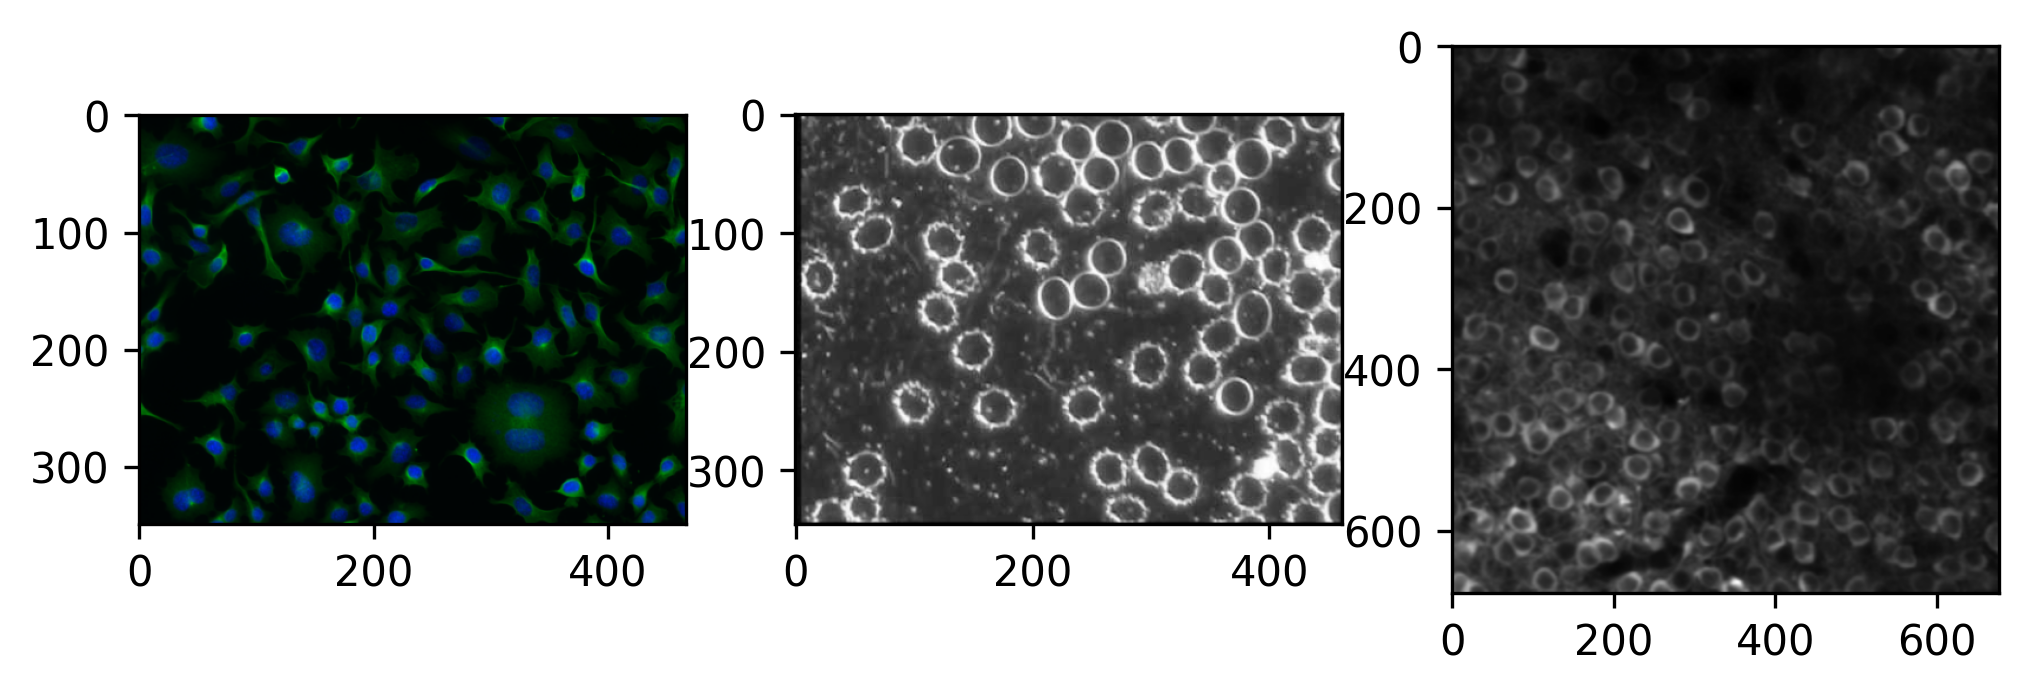

In [6]:
# I will download images from website
urls = ['https://www.cellpose.org/static/images/img02.png',
        'https://www.cellpose.org/static/images/img03.png',
        'https://www.cellpose.org/static/images/img05.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']
    
imgs = [skimage.io.imread(f) for f in files]
nimg = len(imgs)

plt.figure(figsize=(8,4))
for k,img in enumerate(imgs):
  plt.subplot(1,3,k+1)
  plt.imshow(img)

## run cellpose on sample images

In [26]:
# RUN CELLPOSE

from cellpose import models

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=use_GPU, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

masks, flows, styles, diams = model.eval(imgs, diameter=None, flow_threshold=None, channels=channels)

  0%|          | 0/3 [00:00<?, ?it/s]

>>>> using GPU
processing 3 image(s)


  0%|          | 0/3 [00:00<?, ?it/s]

estimated cell diameters for all images


100%|██████████| 3/3 [00:06<00:00,  2.03s/it]


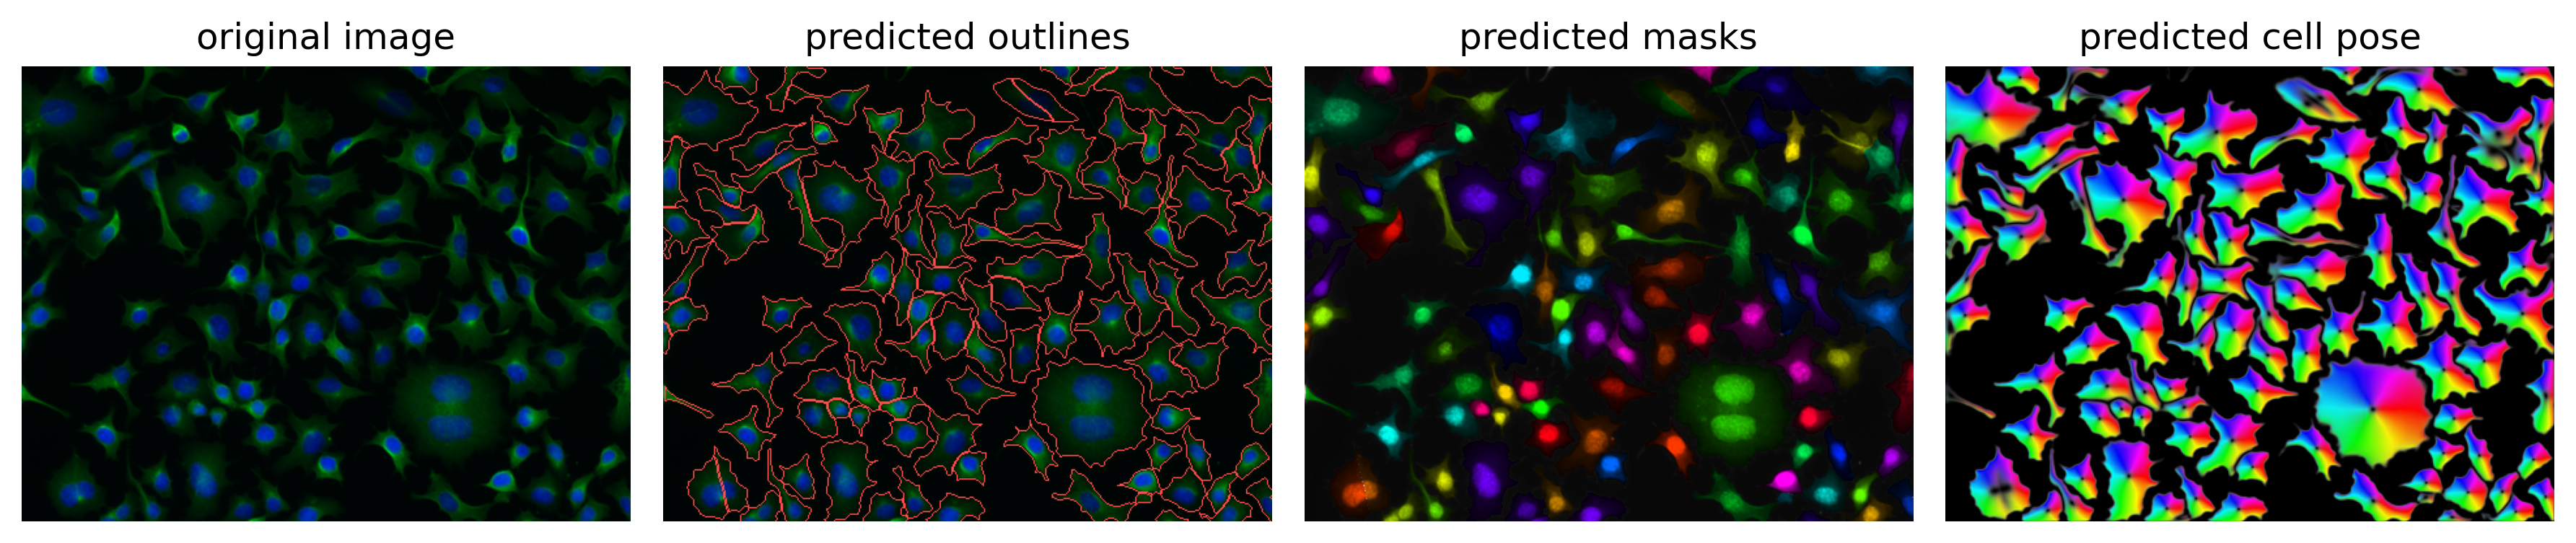

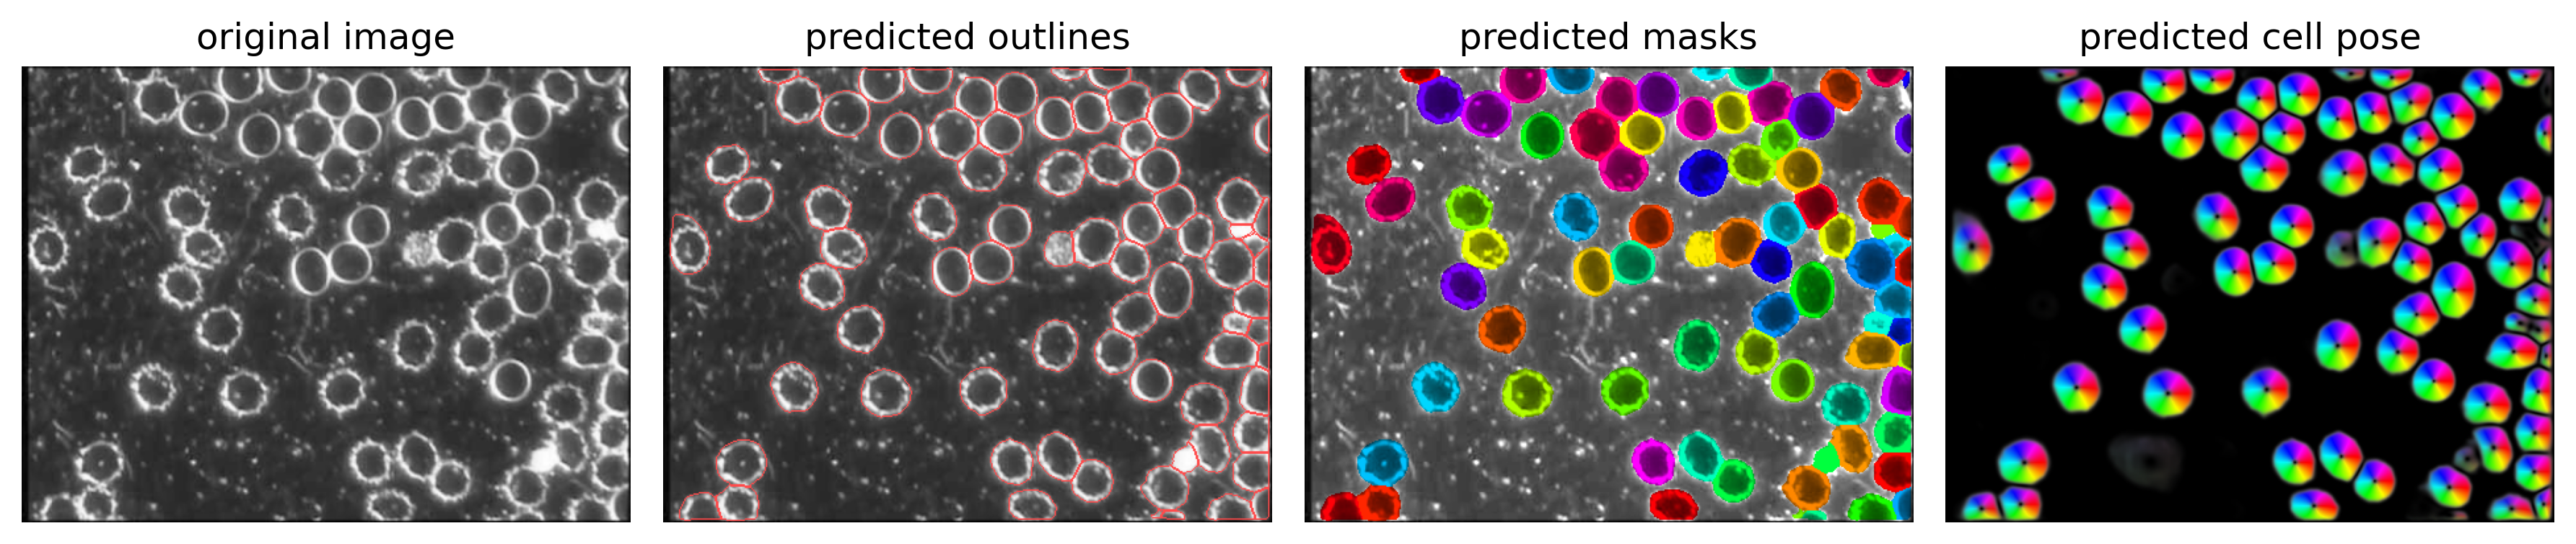

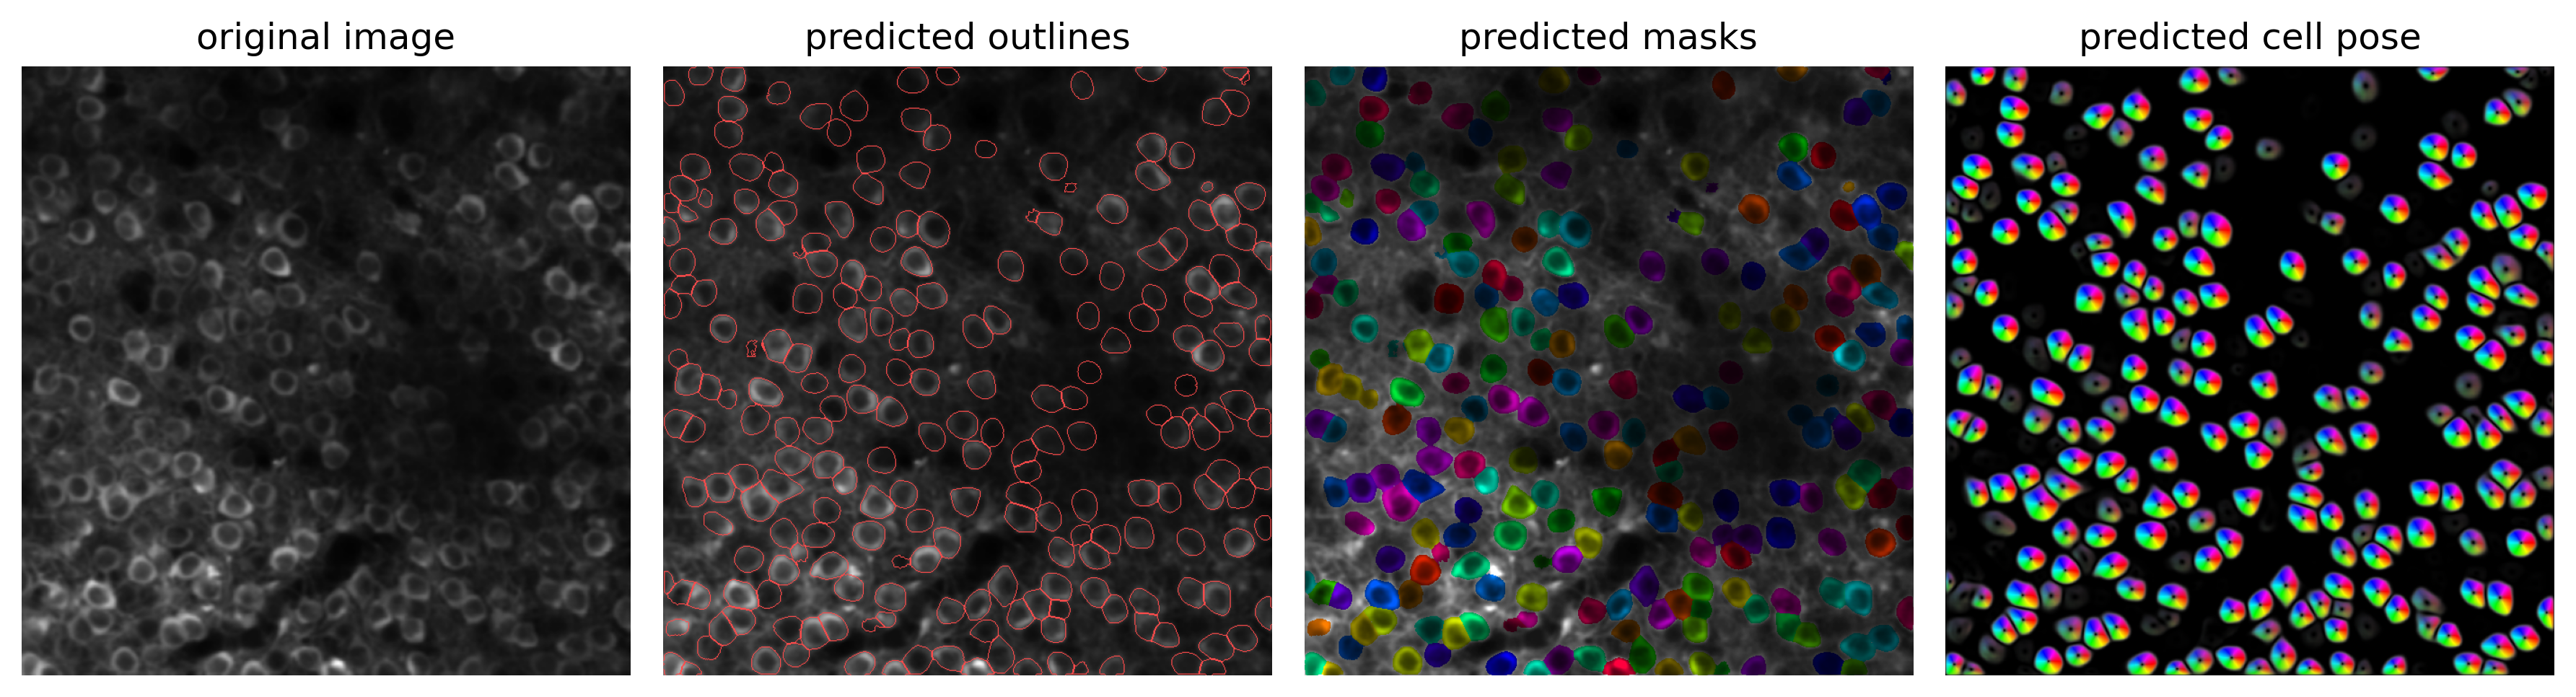

In [27]:
# DISPLAY RESULTS
from cellpose import plot

nimg = len(imgs)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, imgs[idx], maski, flowi, channels=channels[idx])
    plt.tight_layout()
    plt.show()

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [0]:
from cellpose import io

io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)

## connect to your google drive

so that you can run your own files (alternatively, upload them directly to the Files tab)

In [0]:
## RUN THIS CELL TO ACCESS GOOGLE DRIVE

# mount your google drive here if you want to access your own files
from google.colab import drive
drive.mount('/content/drive')

# files will be in
# file_root = '/content/drive/My Drive/'

## run cellpose 3D

In [9]:
# test 3D stack

# in this example I'm using a random matrix, put your own data here
data = np.random.randn(120,512,512).astype(np.float32)

# with 3D you have to set the diameter manually (no auto detect)
masks, flows, styles, diams = model.eval(data, channels=[0,0], diameter=30, do_3D=True)

multi-stack tiff read in as having is 120 planes 1 channels
processing 1 image(s)


  0%|          | 0/120 [00:00<?, ?it/s]

running XY (512, 512)



  0%|          | 0/512 [00:00<?, ?it/s]

running XZ (120, 512)



  0%|          | 0/512 [00:00<?, ?it/s]

running YZ (120, 512)



100%|██████████| 512/512 [07:23<00:00,  1.16it/s]


flows computed 1043.08s
dynamics computed 1303.89s
masks computed 1312.56s
